<h1>README</h1>
<h2>About Cross section</h2>
The code compute inelastic cross sections (xs) from Gean4 simulations. <b>Hadr03</b> example was taken as reference for xs evaluation.

The G4 simulation computes the frequency distribution of particle tracklength interacting with a seminfinite phantom. The tracklength distribution follows the equation: 

\begin{equation}
\frac{N(\lambda)}{N_0}=e^{-\lambda \sigma \frac{N_A\rho}{A}}
\end{equation}

where $\lambda$ is the mean free path, $N_0$ is the number of events, $\sigma$ is teh interaction cross section and $\frac{N_A\rho}{A}$ numerical density of the target.

For a range of energies within 1-100 MeV the simulation computes the tracklegth histogram and the number of secondary particles produced during the inelastic interaction. in order to calculate the xs of a specific reaction channel (e.g. $^{12}C(p,xn)$), the following quation was used:

\begin{equation}
\sigma_i=\frac{N_i}{N_0}\sigma
\end{equation}

where $\sigma_i$ is the xs for the i-th channel and $N_i$ is the number of times i-th channel was produced over $N_0$ events.

<h2>About Analysis</h2>
The code is divided in 4 main live script panels:
<ol>
<li> You can set TALYS and Geant4 folder. In the first panel it takes the main information from geant4 simulations and computs the total inelastic cross section as above. In output the code plots the inelastic cross section and the meanf free path for 3 energies
<li> The code computes the channel reaction cross section for geant4 simulations
<li> The code takes the TALYS cross sections
<li> The code plots cross sections between TALYS and Geant4
</ol>
The python code reads both Geant4 files and TALYS files and computes xs.
Concerning G4 simulations:
<ol>
<li> The code reads the <i>HISTO_TGT_XXpYY.txt</i> where the tracklength histgram is stored. The bins are not included in the file
<li> The code takes target information and number of secondary particles produced reading the <i>SUMMARY_TGT_XXpYY.txt</i> file.
</ol>

<h3>Variables:</h3>
<ol>
<li> <b>talyspath</b>: path of talys files
<li> <b>path</b>: path of G4 files
<li> <b>MFP_Ene</b>: Data Frame->columns = Bins / energies, raws counts of tracklegth per energy
<li> <b>particles</b>: dictionary of dictionary = {'energy':dict_particles}->dict_particles={'particle':counts}.
     <br>
    Example: Number_of_gamma_50MeV = particles['50']['gamma']
    
<li> <b>N_Inel</b>: dictionary of number of inelastic interaction as a function of energy
<li> <b>XS</b>: DataFrame of Fit Parameter + Inealsti cross sections + particle xs
</ol>

****** SIMULATION INFO *****

EVENTS: 10000.0
TARGET: Y89
DENSITY: 4.472 g/cm3


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


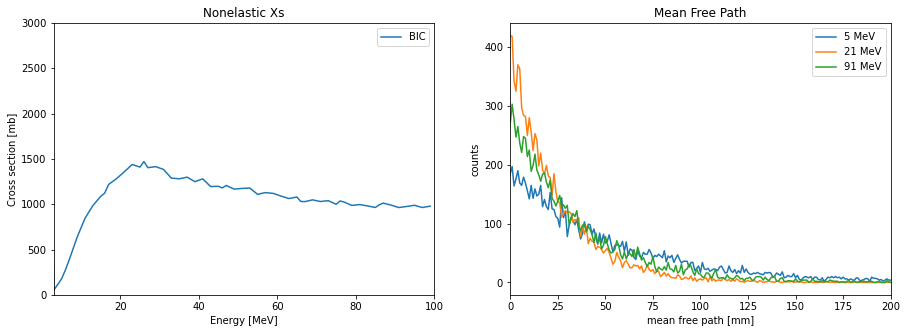

In [129]:
talyspath = "/Users/giorgio/Documents/PhD/PromptGamma/TALYS/"
G4path = "/Users/giorgio/Documents/PhD/G4_PG/CrossSectionPG/HardXS-build/Y89/"

import os
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

#FIT FUNCTION
def f(x, a, b, c):
    return a+(b*np.exp(-c*x))

#GET SUMMARY INFO
def GetTARGETInfo(G4path,filename):
    Ntot = 1
    Ninteraction = 1
    density = 0
    target = ''
    energy = filename[filename.rfind("_")+1:filename.rfind("_")+3]
    tmp = 1e3
    f = open(G4path+filename, 'r')
    for i, line in enumerate(f):
        if i == 0:
            Ntot = float(line[line.find('->')+2:line.find('\n')])
        if i == 1:
            target = line[line.find('->')+2:line.find('\n')]
        elif i==2:
            density = float(line[line.find('->')+2:line.find('->')+2+5])
        elif line.find("protonInelastic") != -1:
            tmp = i
            Ninteraction = float(line[line.find('->')+2:line.find('\n')])
        elif i>tmp:
            break 
    f.close()
    return Ntot, Ninteraction, energy, target, density

def GetHISTOInfo(G4path, filename):
    energy = filename[filename.find("_")+1:filename.find("_")+3]
    data = pd.read_csv(G4path+filename, skiprows=7)
    MFP = data["0"]
    
    return energy, MFP

def GetPARTICLEInfo(G4path,filename):
    output = {}
    index = 1e5
    f = open(G4path+filename, 'r')
    for i, line in enumerate(f):
        if(line.find("PARTICLES") != -1):
            index = i
        if i>index:
            output[line[:line.find("->")]] = float(line[line.find("->")+2:])
    f.close()
    
    return output
    

#MAIN ANALYSIS
#GET TRACKLENGHT FROM G4 FILES
MFP_Ene = pd.DataFrame() #dataframe[energy] = [histo of tracklegth]
MFP_Ene['Bins'] = list(range(1000))

density = 0
events = 1
N_pInel = {}
target = ''

#particles will be  a dictionary={energy:dictionary} of dictionaries
#at each energy is associated a dictionary={particle:counts}
particles = {}
files = os.listdir(G4path)
try:
    for filename in files:
        #print(filename)
            #FIND SUMMARY FILES
        if filename.find("SUMMARY") != -1:
            #GET TARGET INFO PER ENERGY
            events, inel, energy, target, density = GetTARGETInfo(G4path, filename)
           #GET PARTICLES COUNTS PER ENERGY
            particles[energy] = GetPARTICLEInfo(G4path, filename)
            #GET ProtonINELASTIC interaction
            N_pInel[energy] = inel
        #FIND HISTO FILES
        elif filename.find("HISTO") != -1:
            #GET HISTO OF TRACKLEGTH PER ENERGY
            energy, MFP = GetHISTOInfo(G4path, filename)
            MFP_Ene[energy] = MFP
except Exception: #SKIP ERRORS
    print('Errore')
    pass
    

print("****** SIMULATION INFO *****\n")
print("EVENTS:", events)
print("TARGET:", target)
print("DENSITY:", density, "g/cm3")


#FIT TRACKLEGHT HISTOS FOR CROSSS SECTIONS
XS = pd.DataFrame() #cross section dataframe, Energy, FitParameter, nonelastics-xs, etc.
vec_fitPar = list()
vec_energy = list()
for ene in MFP_Ene.columns:
    if ene != "Bins":
        #FIT
        popt, pcov = curve_fit(f, MFP_Ene["Bins"], MFP_Ene[ene]) 
        #GET EXPONENTIAL PARAMETER
        vec_fitPar.append(popt[2])
        if ene[1] == 'p':
            vec_energy.append(float(ene[0]))
        else:
            vec_energy.append(float(ene))
            
XS['Energy'] = vec_energy
XS['ExpFit'] = vec_fitPar

#From fit to Xs -> xs=l*A/(Na*Rho) [cm] -> xs*cmquad2barn_Na*1000 [mb]
cmquad2mbarn_Na = (1/6.022)*10 #factor from cm2 to barn per Avogadro number
Na = 6.022e23
A=1
if target == 'Y89':
    A=89
elif target =='Cu63':
    A=63
elif target =='C12':
    A=12
elif target =='O16':
    A=16

#GET TOTAL NON ELASTIC CROSS SECTION
XS['Xs_nonelastic[mb]'] = XS['ExpFit']*A*cmquad2mbarn_Na*1000/density

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_nonelastic[mb]'], label='BIC')
axs[0].set_xlim(3,100)
axs[0].set_ylim(0,3000)
axs[0].set_xlabel("Energy [MeV]")
axs[0].set_ylabel("Cross section [mb]")
axs[0].set_title("Nonelastic Xs")
axs[0].legend()

axs[1].plot(MFP_Ene["Bins"], MFP_Ene["9p"], label='5 MeV')
axs[1].plot(MFP_Ene["Bins"], MFP_Ene["21"], label='21 MeV')
axs[1].plot(MFP_Ene["Bins"], MFP_Ene["91"], label='91 MeV')
axs[1].set_xlim(0,200)
axs[1].set_ylabel("counts")
axs[1].set_xlabel("mean free path [mm]")
axs[1].set_title("Mean Free Path")
axs[1].legend()


In [130]:
#GET SECONDARY PARTICLES: GAMMA, NEUTRONS, PROTONS, ALPHAS
vec_pInelastic = list()
vec_gamma = list()
vec_proton = list()
vec_alpha = list()
vec_neutron = list()
vec_pg = list()
for ene in MFP_Ene.columns:
    if ene != "Bins":
        vec_pInelastic.append(N_pInel[ene])
        try:
            vec_gamma.append(particles[ene]["gamma"]) #GET GAMMA PER ENERGY
        except:
            vec_gamma.append(0.)
        try:
            vec_proton.append(particles[ene]["proton"]) #GET p PER ENERGY
        except:
            vec_proton.append(0.)
            
        try:
            vec_alpha.append(particles[ene]["alpha"]) #GET a PER ENERGY
        except:
            vec_alpha.append(0.)
            
        try:
            vec_neutron.append(particles[ene]["neutron"]) #GET n PER ENERGY
        except:
            vec_neutron.append(0.)
            
        try:
            if target == 'Y89':
                vec_pg.append(particles[ene]["Zr90"]) #GET Zr90 PER ENERGY
            elif target =='Cu63':
                vec_pg.append(particles[ene]["Zn64"]) #GET Zr90 PER ENERGY
            elif target =='C12':
                vec_pg.append(particles[ene]["N13"]) #GET Zr90 PER ENERGY
            elif target =='O16':
                vec_pg.append(particles[ene]["Li7"]) #GET Zr90 PER ENERGY
        except:
            vec_pg.append(0.)
            
        
XS['N_of_pInel'] = vec_pInelastic

XS['N_of_gamma'] = vec_gamma
XS['Xs_gamma[mb]'] = XS['Xs_nonelastic[mb]']*XS['N_of_gamma']/XS['N_of_pInel']

XS['N_of_proton'] = vec_proton
XS['Xs_proton[mb]'] = XS['Xs_nonelastic[mb]']*XS['N_of_proton']/XS['N_of_pInel']

XS['N_of_alpha'] = vec_alpha
XS['Xs_alpha[mb]'] = XS['Xs_nonelastic[mb]']*XS['N_of_alpha']/XS['N_of_pInel']

XS['N_of_nutron'] = vec_neutron
XS['Xs_neutron[mb]'] = XS['Xs_nonelastic[mb]']*XS['N_of_nutron']/XS['N_of_pInel']

XS['N_of_pg'] = vec_pg
XS['Xs_pg[mb]'] = XS['Xs_nonelastic[mb]']*XS['N_of_pg']/XS['N_of_pInel']

XS.head()

,Energy,ExpFit,Xs_nonelastic[mb],N_of_pInel,N_of_gamma,Xs_gamma[mb],N_of_proton,Xs_proton[mb],N_of_alpha,Xs_alpha[mb],N_of_nutron,Xs_neutron[mb],N_of_pg,Xs_pg[mb]
0,86.0,0.030054,993.218167,10000.0,72956.0,7246.122456,10918.0,1084.395594,1492.0,148.188150,24116.0,2395.244930,0.0,0.000000
1,67.0,0.031110,1028.136495,10000.0,73615.0,7568.626806,9328.0,959.045722,1122.0,115.356915,21380.0,2198.155826,0.0,0.000000
2,43.0,0.036155,1194.867086,10000.0,76494.0,9140.016286,5971.0,713.455137,707.0,84.477103,17033.0,2035.217107,0.0,0.000000
3,6.0,0.008342,275.691550,10000.0,19591.0,540.107316,3.0,0.082707,0.0,0.000000,1285.0,35.426364,8712.0,240.182478
4,39.0,0.037784,1248.690144,10000.0,74506.0,9303.490788,5610.0,700.515171,619.0,77.293920,16321.0,2037.987184,0.0,0.000000


In [131]:
#TALYS XS
xs = {}
gSF = {}
if target == 'Y89':
    #Y89
    #nonelastic
    xs["nonel"] = np.loadtxt(talyspath+"Y89_p/output/nonelastic.tot")
    #neutron production
    xs["p,xn"] = np.loadtxt(talyspath+"Y89_p/output/nprod.tot")
    #proton production
    xs["p,xp"] = np.loadtxt(talyspath+"Y89_p/output/pprod.tot")
    #deuteron production
    xs["p,xd"] = np.loadtxt(talyspath+"Y89_p/output/dprod.tot")
    #alpha production
    xs["p,xa"] = np.loadtxt(talyspath+"Y89_p/output/aprod.tot")
    #gamma production
    xs["p,xg"] = np.loadtxt(talyspath+"Y89_p/output/gprod.tot")
    xs["p,g"] = np.loadtxt(talyspath+"Y89_p/output/rp040090.tot")
    #gamma strength function l=1
    gSF["gSF"] = np.loadtxt(talyspath+"Y89_p/output/gSF-l1.tot")
elif target =='Cu63':
    A=63
    #C12
    xs["nonel"] = np.loadtxt(talyspath+"Cu63_p/output/nonelastic.tot")
    #neutron production
    xs["p,xn"] = np.loadtxt(talyspath+"Cu63_p/output/nprod.tot")
    #proton production
    xs["p,xp"] = np.loadtxt(talyspath+"Cu63_p/output/pprod.tot")
    #deuteron production
    xs["p,xd"] = np.loadtxt(talyspath+"Cu63_p/output/dprod.tot")
    #alpha production
    xs["p,xa"] = np.loadtxt(talyspath+"Cu63_p/output/aprod.tot")
    #gamma production
    xs["p,xg"] = np.loadtxt(talyspath+"Cu63_p/output/gprod.tot")
    xs["p,g"] = np.loadtxt(talyspath+"Cu63_p/output/rp030064.tot")
    #gamma strength function l=1
    #gSF["gSF"] = np.loadtxt(talyspath+"Cu63_p/output/gSF-l1.tot")
elif target =='C12':
    A=12
    #C12
    xs["nonel"] = np.loadtxt(talyspath+"C12_p/output/nonelastic.tot")
    #neutron production
    xs["p,xn"] = np.loadtxt(talyspath+"C12_p/output/nprod.tot")
    #proton production
    xs["p,xp"] = np.loadtxt(talyspath+"C12_p/output/pprod.tot")
    #deuteron production
    xs["p,xd"] = np.loadtxt(talyspath+"C12_p/output/dprod.tot")
    #alpha production
    xs["p,xa"] = np.loadtxt(talyspath+"C12_p/output/aprod.tot")
    #gamma production
    xs["p,xg"] = np.loadtxt(talyspath+"C12_p/output/gprod.tot")
    xs["p,g"] = np.loadtxt(talyspath+"C12_p/output/rp006011.tot")
    #gamma strength function l=1
    gSF["gSF"] = np.loadtxt(talyspath+"C12_p/output/gSF-l1.tot")
elif target =='O16':
    A=16
    xs["nonel"] = np.loadtxt(talyspath+"O16_p/output/nonelastic.tot")
    #neutron production
    xs["p,xn"] = np.loadtxt(talyspath+"O16_p/output/nprod.tot")
    #proton production
    xs["p,xp"] = np.loadtxt(talyspath+"O16_p/output/pprod.tot")
    #deuteron production
    xs["p,xd"] = np.loadtxt(talyspath+"O16_p/output/dprod.tot")
    #alpha production
    xs["p,xa"] = np.loadtxt(talyspath+"O16_p/output/aprod.tot")
    #gamma production
    xs["p,xg"] = np.loadtxt(talyspath+"O16_p/output/gprod.tot")
    xs["p,g"] = np.loadtxt(talyspath+"O16_p/output/rp003007.tot")
    #gamma strength function l=1
    gSF["gSF"] = np.loadtxt(talyspath+"O16_p/output/gSF-l1.tot")

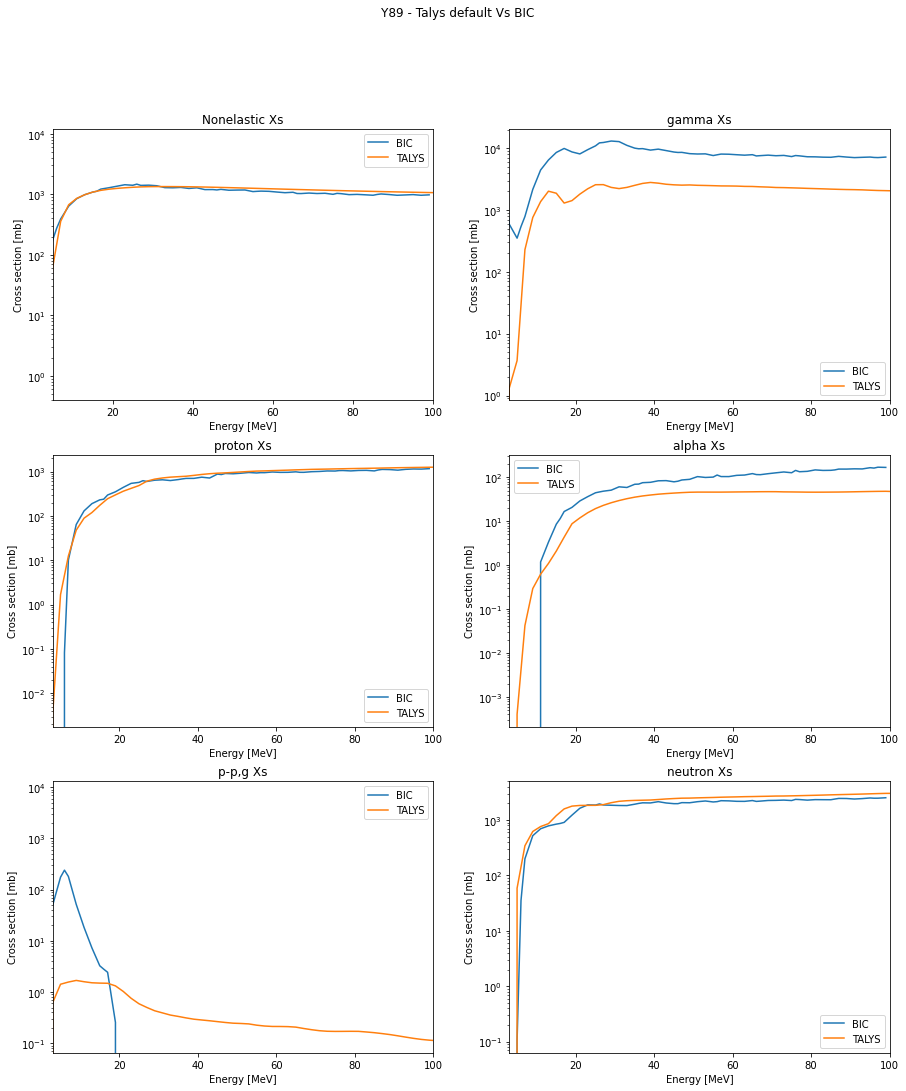

In [132]:
#PLOT
fig, axs = plt.subplots(3,2, figsize=(15,17))
fig.suptitle(target + ' - Talys default Vs BIC')

#particles and gammas production xs - TALYS(default)
axs[0,0].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_nonelastic[mb]'], label='BIC')
axs[0,0].plot(xs["nonel"][:, 0], xs["nonel"][:, 1], label='TALYS')
axs[0,0].set_xlim(5,100)
#axs[0,0].set_ylim(0,3000)
axs[0,0].set_yscale('log')

axs[0,0].set_xlabel("Energy [MeV]")
axs[0,0].set_ylabel("Cross section [mb]")
axs[0,0].set_title("Nonelastic Xs")
axs[0,0].legend()


#(p,g) vs total gamma production
#particles and gammas production xs - TALYS(default)
axs[0,1].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_gamma[mb]'], label='BIC')
axs[0,1].plot(xs["p,xg"][:, 0], xs["p,xg"][:, 1], label='TALYS')
axs[0,1].set_xlim(3,100)
#axs[0,1].set_ylim(0,30000)
axs[0,1].set_yscale('log')

axs[0,1].set_xlabel("Energy [MeV]")
axs[0,1].set_ylabel("Cross section [mb]")
axs[0,1].set_title("gamma Xs")
axs[0,1].legend()

#(p,) vs total gamma production
#particles and gammas production xs - TALYS(default)
axs[1,0].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_proton[mb]'], label='BIC')
axs[1,0].plot(xs["p,xp"][:, 0], xs["p,xp"][:, 1], label='TALYS')
axs[1,0].set_xlim(3,100)
#axs[1,0].set_ylim(0,1000)
axs[1,0].set_yscale('log')

axs[1,0].set_xlabel("Energy [MeV]")
axs[1,0].set_ylabel("Cross section [mb]")
axs[1,0].set_title("proton Xs")
axs[1,0].legend()

#(p,) vs total gamma production
#particles and gammas production xs - TALYS(default)
axs[1,1].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_alpha[mb]'], label='BIC')
axs[1,1].plot(xs["p,xa"][:, 0], xs["p,xa"][:, 1], label='TALYS')
axs[1,1].set_xlim(3,100)
#axs[0,1].set_ylim(0,1000)
axs[1,1].set_yscale('log')

axs[1,1].set_xlabel("Energy [MeV]")
axs[1,1].set_ylabel("Cross section [mb]")
axs[1,1].set_title("alpha Xs")
axs[1,1].legend()

#(p,) vs total gamma production
#particles and gammas production xs - TALYS(default)
axs[2,0].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_pg[mb]'], label='BIC')
axs[2,0].plot(xs["p,g"][:, 0], xs["p,g"][:, 1], label='TALYS')
axs[2,0].set_xlim(3,100)
#axs[2,0].set_ylim(0,3000)
axs[2,0].set_yscale('log')

axs[2,0].set_xlabel("Energy [MeV]")
axs[2,0].set_ylabel("Cross section [mb]")
axs[2,0].set_title("p-p,g Xs")
axs[2,0].legend()

#(p,) vs total gamma production
#particles and gammas production xs - TALYS(default)
axs[2,1].plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_neutron[mb]'], label='BIC')
axs[2,1].plot(xs["p,xn"][:, 0], xs["p,xn"][:, 1], label='TALYS')
axs[2,1].set_xlim(3,100)
#axs[2,1].set_ylim(0,3000)
axs[2,1].set_yscale('log')

axs[2,1].set_xlabel("Energy [MeV]")
axs[2,1].set_ylabel("Cross section [mb]")
axs[2,1].set_title("neutron Xs")
axs[2,1].legend()



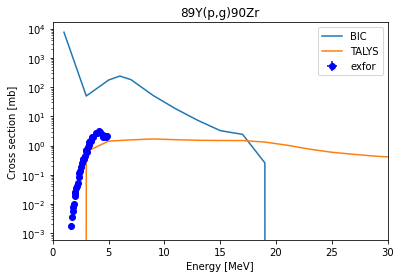

In [136]:
exfor = ''
title = ''
if A == 89:
    exfor = '/Users/giorgio/Documents/PhD/PromptGamma/EXFOR/Y89/rp040090.exfor'
    title = '89Y(p,g)90Zr'
elif A == 63:
    exfor = '/Users/giorgio/Documents/PhD/PromptGamma/EXFOR/Cu63/rp030064.exfor'
    title = '63Cu(p,g)64Zn'
f=open(exfor,"r")
lines=f.readlines()
x = list()
dx = list()
y = list()
dy = list()

for line in lines:
    if(line[0] == ' '):
        x.append(float(line[0:14])) 
        dx.append(float(line[15:27])) 
        y.append(float(line[28:41])*1e3) 
        dy.append(float(line[42:55])*1e3)
f.close()

#(p,) vs total gamma production
#particles and gammas production xs - TALYS(default)
plt.plot(XS.sort_values(by='Energy')['Energy'], XS.sort_values(by='Energy')['Xs_pg[mb]'], label='BIC')
plt.plot(xs["p,g"][:, 0], xs["p,g"][:, 1], label='TALYS')
plt.errorbar(x,y, xerr=dx, yerr=dy, fmt=' ', color='b', marker='o', label='exfor')
plt.xlim(0,30)
#plt.ylim(0,3000)
plt.yscale('log')
#plt.xscale('log')

plt.xlabel("Energy [MeV]")
plt.ylabel("Cross section [mb]")

plt.title(title)
plt.legend()